# Quantum Approximate Optimization Algorithm

![qaoa layers](qaoa_circuit.png "QAOA Circuit")


In [1]:
import pennylane as qml
from pennylane import numpy as np
import cmath

import matplotlib.pyplot as plt
from pennylane import qaoa

Circuits and Hamiltonians
-------------------------

Gates are physically implemented by performing time evolution under a carefully engineered Hamiltonian. These transformations are described by the **time evolution operator**, which is a unitary defined as:

$$U(H, \ t) \ = \ e^{-i H t}.$$

The time evolution operator is determined completely in terms of a
Hamiltonian $H$ and a scalar $t$ representing time. In fact, any unitary
$U$ can be written in the form $e^{i \gamma H}$, where $\gamma$ is a
scalar and $H$ is a Hermitian operator, interpreted as a Hamiltonian.
Thus, time evolution establishes a connection that allows us to describe
quantum circuits in terms of Hamiltonians. 🤯

In general, implementing a quantum circuit that exactly exponentiates a
Hamiltonian with many non-commuting terms, i.e., a Hamiltonian of the
form:

$$H \ = \ H_1 \ + \ H_2 \ + \ H_3 \ + \ \cdots \ + \ H_N,$$

is very challenging. Instead, we can use the
[Trotter-Suzuki](https://en.wikipedia.org/wiki/Lie_product_formula)
decomposition formula

$$e^{A \ + \ B} \ \approx \ \Big(e^{A/n} e^{B/n}\Big)^{n},$$

to implement an *approximate* time-evolution unitary:

$$U(H, t, n) \ = \ \displaystyle\prod_{j \ = \ 1}^{n}
\displaystyle\prod_{k} e^{-i H_k t / n} \ \ \ \ \ \ \ \ \ \ H \
= \ \displaystyle\sum_{k} H_k,$$

where $U$ approaches $e^{-i H t}$ as $n$ becomes larger.


In PennyLane, this is implemented using the
`~.pennylane.templates.ApproxTimeEvolution` template. For example, let\'s say we have the following
Hamiltonian:


In [2]:
import pennylane as qml

H = qml.Hamiltonian(
    [1, 1, 0.5],
    [qml.PauliZ(0), qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1)]
)
print(H)

1 * Z(0) + 1 * Z(1) + 0.5 * (X(0) @ X(1))


We can implement the approximate time-evolution operator corresponding to this Hamiltonian:

In [3]:
dev = qml.device('default.qubit', wires=2)

t = 1
n = 2

@qml.qnode(dev)
def circuit():
    qml.ApproxTimeEvolution(H, t, n)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit, level="device")())

0: ──RZ(1.00)─╭RXX(0.50)──RZ(1.00)─╭RXX(0.50)─┤  <Z>
1: ──RZ(1.00)─╰RXX(0.50)──RZ(1.00)─╰RXX(0.50)─┤  <Z>


### Step 1: Construct the cost Hamiltonian

In [4]:
cost_H = qml.Hamiltonian([1], [qml.PauliZ(0)])


### Step 2: Construct the mixer Hamiltonian

In [5]:
mixer_H = qml.Hamiltonian([1], [qml.PauliX(0)])

In [6]:
### Step 3: Set hyperparameters
dev = qml.device('default.qubit', wires=1)
wires=[0]
num_layers = 4

### Step 4: Layering circuits

Think of all the times you have copied a text or image, then pasted it repeatedly to create many duplicates. This is also a useful feature when designing quantum algorithms! The idea of repetition is ubiquitous in quantum computing: from amplitude amplification in Grover’s algorithm to layers in quantum neural networks and Hamiltonian simulation, repeated application of a circuit is a central tool in quantum algorithms.

In [7]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_H)
    qaoa.mixer_layer(alpha, mixer_H)


def circuit(params):
    for w in wires:
        qml.Hadamard(w)
    qml.layer(qaoa_layer, num_layers, params[0], params[1])


dev = qml.device('default.qubit', wires=1)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_H)

In [8]:
optimizer = qml.GradientDescentOptimizer()
steps = 70
params = np.array([[0.5, 0.5, 0.5, 0.5] ,[0.5, 0.5, 0.5, 0.5]], requires_grad=True)

In [9]:
for _ in range(steps):
    params = optimizer.step(cost_function, params)

In [10]:
@qml.qnode(dev)
def circuit_state(params):
    circuit(params)
    return qml.state()

In [11]:
np.round(circuit_state(params), decimals=5)

tensor([-7.9e-04-0.00011j, -1.0e+00-0.j     ], requires_grad=True)

## Problems

Use QAOA to find ground states of:
1. $\hat{H} = 3Z_0Z_1$
2. $\hat{H} = \frac{3}{4}(Z_0Z_1 + Z_1Z_2) - Z_0 - Z_1$

## Max Cut with QAOA
$$
 H_C \ = \ \frac{1}{2} \displaystyle\sum_{(i, j) \in E(G)} \big( \mathbb{I} \ - \ Z_i Z_j    \big),
$$


In [12]:
import networkx as nx
edges = [(0, 1), (1, 2), (2, 3), (3, 0), (1, 3)]
graph = nx.Graph(edges)

### edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
$$
\begin{align}
H &= \sum_{(i, j)\in E} \frac{1}{2}(1 - z_iz_j) \\
&= \frac{1}{2}(1 - z_0z_1) + \frac{1}{2}(1 - z_1z_2) + \frac{1}{2}(1 - z_2z_0) + \frac{1}{2}(1 - z_2z_3) \\
& = 2 - ( \frac{1}{2}z_0z_1 + \frac{1}{2} z_1z_2 + \frac{1}{2} z_2z_0 + \frac{1}{2}z_2z_3)
\end{align}
$$


In general, 
$$
\begin{align}
H &= \sum_{(i, j)\in E} \frac{1}{2}(1 - z_iz_j) \\
&= \frac{|E|}{2} - \sum_{(i, j)\in E} \frac{1}{2}(z_iz_j)
\end{align}
$$

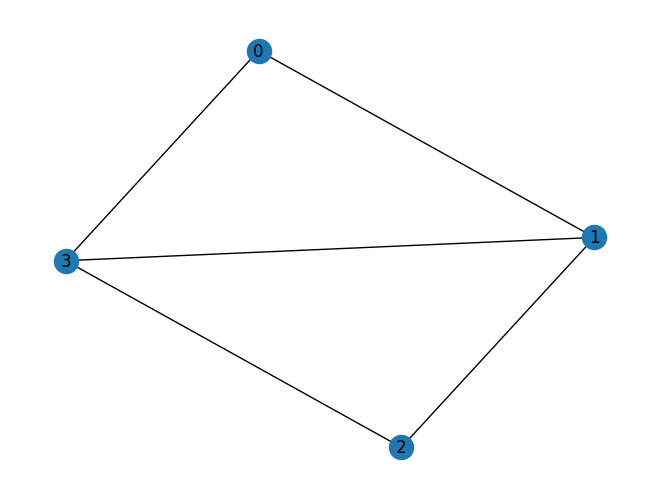

In [13]:
nx.draw(graph, with_labels = True)

## Pre-made Hamiltonians in PennyLane
PennyLane provides provides a collection of methods that help in the construction of QAOA workflows.

In [14]:
cost_h, mixer_h = qml.qaoa.maxcut(graph)

In [15]:
cost_h

(
    0.5 * (Z(0) @ Z(1))
  + 0.5 * (Z(0) @ Z(3))
  + 0.5 * (Z(1) @ Z(2))
  + 0.5 * (Z(1) @ Z(3))
  + 0.5 * (Z(2) @ Z(3))
  + -0.5 * (I(0) @ I(1))
  + -0.5 * (I(0) @ I(3))
  + -0.5 * (I(1) @ I(2))
  + -0.5 * (I(1) @ I(3))
  + -0.5 * (I(2) @ I(3))
)

In [16]:
# (-1)*maxcut_ham

In [17]:
mixer_h

1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3)

# MaxCut QAOA
The quantum approximate optimization algorithm (QAOA) is a general
technique that can be used to find approximate solutions to
combinatorial optimization problems, in particular problems that can be
cast as searching for an optimal bitstring. QAOA consists of the
following steps:

1.  Define a *cost Hamiltonian* $H_C$ such that its ground state encodes
    the solution to the optimization problem.

2.  Define a *mixer Hamiltonian* $H_M$.

3.  Construct the circuits $e^{-i \gamma H_C}$ and $e^{-i\alpha H_M}$.
    We call these the *cost* and *mixer layers*, respectively.

4.  Choose a parameter $n\geq 1$ and build the circuit

    $$U(\boldsymbol\gamma, \ \boldsymbol\alpha) \ = \ e^{-i \alpha_n H_M}
    e^{-i \gamma_n H_C} \ ... \ e^{-i \alpha_1 H_M} e^{-i \gamma_1 H_C},$$

    consisting of repeated application of the cost and mixer layers.

5.  Prepare an initial state, apply
    $U(\boldsymbol\gamma,\boldsymbol\alpha)$, and use classical
    techniques to optimize the parameters.

6.  After the circuit has been optimized, measurements of the output
    state reveal approximate solutions to the optimization problem.

In summary, the starting point of QAOA is the specification of cost and
mixer Hamiltonians. We then use time evolution and layering to create a
variational circuit and optimize its parameters. The algorithm concludes
by sampling from the circuit to get an approximate solution to the
optimization problem. Let\'s see it in action! 🚀

In [18]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [19]:
wires = range(4)
layers = 2

In [20]:
def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, layers, params[0], params[1])

In [21]:
dev = qml.device("default.qubit", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

In [22]:
optimizer = qml.GradientDescentOptimizer()
steps = 12
params = np.array([[0.2, 0.2], [0.2, 0.2]], requires_grad=True)

In [23]:
for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

/home/alex/anaconda3/envs/seng457/lib/python3.13/site-packages/pennylane/ops/op_math/composite.py:209: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in staticmethod() if you want to preserve the old behavior
  return self._math_op(math.vstack(eigvals), axis=0)


Optimal Parameters
[[-0.07589978  0.08046374]
 [ 0.17524738  0.03745729]]


In [24]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

In [25]:
binary_labels = [format(i, '0' + str((len(wires))) + 'b') for i in range(2 **(len(wires)))]

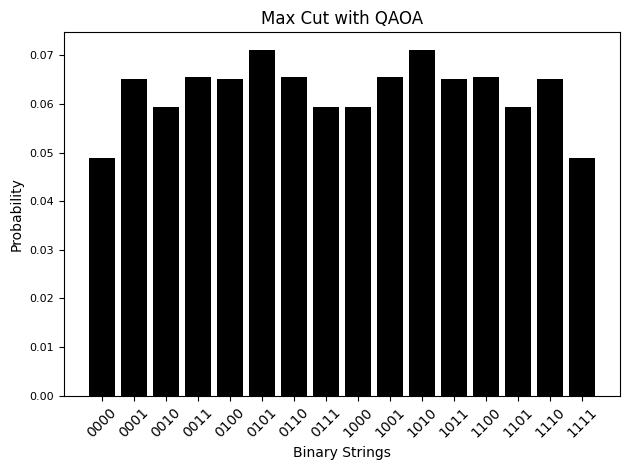

In [26]:
import matplotlib.pyplot as plt

# Your data
# Assuming you have defined wires, probs, binary_labels, layers, and steps earlier

# Plotting
plt.bar(range(2 ** len(wires)), probs, color='black')  # Set color to black
plt.xticks(range(2 ** len(wires)), binary_labels, rotation=45, fontsize=10) 
plt.yticks(fontsize=8)
plt.xlabel('Binary Strings', fontsize=10)
plt.ylabel('Probability', fontsize=10)
#plt.title(f'Max Cut with QAOA\nLayers: {layers}, Steps: {steps}, Optimizer: Gradient Descent', fontsize=12)
plt.title('Max Cut with QAOA')
# Add gridlines
# plt.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.savefig("graph")


Reference: https://pennylane.ai/qml/demos/tutorial_qaoa_intro